# Simulation of Fermi-Dirac distribution to understand markets

2024-11-10

Seems that (mathematically defined) market is similar to Fermi-Dirac distribution.

To appreciate this simulate the following systems:
1. Proper FD energy levels with 0/1 allowed particles
2. Loosely degenerate FD energy levels with M particles per level
3. Energy levels with random and mutually different particle capacities {Mi}

In [1]:
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit, minimize, root

## 1. Proper FD system with 0/1 occupancy

Result:
- 2k steps good enought for 100 levels and 20 particles, after 1k global minimum pretty much reached

In [85]:
# main fixed parameters
NE = 100  # number of energy levels
N = 20  # number of particles
T = 0.1  # temperature

Es = np.arange(0, NE, 1)  # energy levels

In [86]:
# theoretical minimal energy
np.array([1] * N + [0] * (NE - N)) @ Es

190

In [87]:
# simulation buffers
Ns = np.zeros_like(Es)  # particle occupations

# generate initial particle occupations
np.random.seed(43)

n_trials = 0
while True:
    # Ns = (np.random.randint(0, 100, size=NE) < 20).astype(int)
    Ns = (np.random.randint(0, NE//N*20, size=NE) < N).astype(int)
    n_trials += 1
    if Ns.sum() == N:
        break

print(f'Number of trials: {n_trials}')

Number of trials: 8


In [67]:
%%time

# MC simulation
n_steps = int(2e3)
n_eq = n_steps // 2  # equilibration
n_sim = n_steps - n_eq

# simulation buffers
energies = []
avg_Es = np.zeros_like(Es)
avg_Ns = np.zeros_like(Ns)

n_swap = 0  # number of successful swaps

for step in range(n_steps):
    # select proper levels
    while True:
        i = np.random.randint(NE)
        j = np.random.randint(NE)
        if i != j and Ns[i] == 1 and Ns[j] == 0:
            break

    # swap particles
    Ns[i] -= 1
    Ns[j] += 1
    dE = Es[j] - Es[i]

    # perform Metropolis step, return to orign conf
    if np.exp(-dE/T) <= np.random.rand():
        # reject
        Ns[i] += 1
        Ns[j] -= 1
    else:
        # accept
        n_swap += 1
    
    # compute observables
    E = Ns @ Es
    energies.append(E)
    if step >= n_eq:
        avg_Ns += Ns

    if step % 20 == 0:
        print(step, n_swap, E, dE)

0 1 852 -48
20 5 692 15
40 9 591 75
60 12 513 21
80 13 472 34
100 15 430 6
120 19 366 -7
140 23 331 -18
160 24 300 78
180 24 300 75
200 25 277 17
220 26 273 20
240 27 261 -12
260 27 261 38
280 27 261 41
300 27 261 10
320 27 261 52
340 27 261 71
360 27 261 48
380 28 258 9
400 28 258 89
420 29 254 34
440 29 254 56
460 29 254 70
480 31 247 32
500 32 239 56
520 32 239 51
540 33 238 14
560 34 233 42
580 35 221 47
600 35 221 82
620 35 221 42
640 35 221 61
660 36 216 71
680 36 216 47
700 36 216 47
720 36 216 84
740 36 216 85
760 36 216 40
780 36 216 43
800 36 216 26
820 37 212 -4
840 37 212 78
860 37 212 68
880 37 212 81
900 38 204 21
920 38 204 67
940 39 203 7
960 39 203 76
980 39 203 48
1000 39 203 88
1020 39 203 21
1040 39 203 37
1060 39 203 12
1080 42 198 42
1100 42 198 67
1120 43 190 18
1140 43 190 16
1160 43 190 21
1180 43 190 22
1200 43 190 42
1220 43 190 70
1240 43 190 87
1260 43 190 27
1280 43 190 13
1300 43 190 98
1320 43 190 23
1340 43 190 82
1360 43 190 73
1380 43 190 29
1400 43 1

In [68]:
px.line(energies)

In [69]:
px.line(avg_Ns / n_sim)

## 2. Loose FD system with fixed $M$ occupancy

Result: works for $M=5$, in 4k steps global minimum reached for 100 energy levels and 200 particles.

In [57]:
def exp_bounding_fun(x):
    '''Prevent overflow in exponential'''
    return min(0, max(-100, x))

In [284]:
# main fixed parameters
NE = 100  # number of energy levels
N = 150  # number of particles
M = 5  # max occupancy/capacity
T = 3.0  # temperature

Es = np.arange(0, NE, 1)  # energy levels

In [285]:
# theoretical minimal energy
last_occ_level = int(np.ceil(N / M))
np.array([M] * last_occ_level + [0] * (NE - last_occ_level)) @ Es

2175

In [286]:
# simulation vectors
Es = np.arange(0, NE, 1)  # redefine
Ns = np.zeros_like(Es)  # particle occupations

# generate initial particle occupations, all particles to highest levels
last_occ_level = N // M
Ns = np.array([0] * (NE - last_occ_level) + [M] * last_occ_level)
Ns.sum()

150

In [287]:
%%time

np.random.seed(43)

# MC simulation
n_steps = int(4e3)
n_sim = int(1e3)  # steps after equilibration
n_eq = n_steps - n_sim  # equilibration

# simulation buffers
energies = []
avg_Es = np.zeros_like(Es)
avg_Ns = np.zeros_like(Ns)

n_swap = 0  # number of successful swaps

for step in range(n_steps):
    # select proper levels
    while True:
        i = np.random.randint(NE)
        j = np.random.randint(NE)
        if i != j and Ns[i] > 0 and Ns[j] < M:
            break

    # swap particles
    Ns[i] -= 1
    Ns[j] += 1
    dE = Es[j] - Es[i]

    # perform Metropolis step, return to orign conf, prevent overflow in exp
    if np.exp(exp_bounding_fun(-dE/T)) <= np.random.rand():
        # reject
        Ns[i] += 1
        Ns[j] -= 1
    else:
        # accept
        n_swap += 1
    
    # compute observables
    E = Ns @ Es
    energies.append(E)
    if step >= n_eq:
        avg_Ns += Ns

    if step % 100 == 0:
        print(step, n_swap, E, dE)

# post-process
avg_Ns = avg_Ns / n_sim

0 1 12652 -23
100 72 9764 -86
200 138 7203 -87
300 184 5590 -71
400 224 4664 -55
500 255 3735 40
600 280 3200 25
700 299 2858 26
800 314 2640 56
900 323 2565 28
1000 335 2449 41
1100 341 2425 27
1200 348 2413 53
1300 354 2379 58
1400 357 2352 48
1500 366 2324 70
1600 370 2316 75
1700 373 2296 57
1800 380 2285 73
1900 383 2262 27
2000 387 2249 -6
2100 388 2258 67
2200 393 2276 80
2300 398 2264 24
2400 403 2263 68
2500 407 2257 8
2600 410 2236 2
2700 416 2216 50
2800 417 2213 34
2900 418 2205 65
3000 420 2221 31
3100 426 2224 -2
3200 428 2209 71
3300 430 2211 22
3400 432 2204 43
3500 432 2204 45
3600 433 2205 52
3700 435 2216 92
3800 435 2216 14
3900 441 2210 39
CPU times: user 120 ms, sys: 4.41 ms, total: 125 ms
Wall time: 230 ms


In [288]:
px.line(energies)

In [289]:
# fit with 
def fit_fun(x, ef):
    return M / (np.exp((x - ef) / T) + 1.0)

popt, pcov = curve_fit(fit_fun, Es, avg_Ns, p0=(20,))
fit_Ns = fit_fun(Es, *popt)

In [290]:
popt

array([29.30864259])

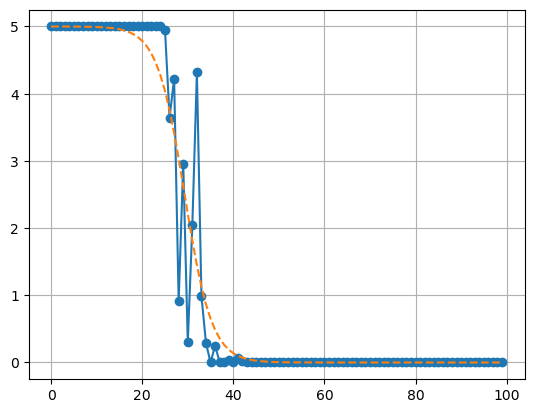

In [291]:
plt.plot(Es, avg_Ns, 'o-', Es, fit_Ns, '--')
plt.grid()

## 3. Market-like FD system with capacities as occupancies

In [59]:
def exp_bounding_fun(x):
    '''Prevent overflow in exponential'''
    return min(0, max(-100, x))

In [61]:
def compute_percentile(Ns, Es, perc, dN):
    '''compute real percentile with weights, Numpy function only available from Numpy 2.0'''
    buf = []
    for i, _ in enumerate(Ns):
        temp_weight = int(Ns[i] / dN)
        buf.extend([Es[i]] * temp_weight)

    return np.percentile(buf, perc, method='nearest')

In [51]:
# write/find function to get a percentile
np.percentile([1, 2], 90, method='nearest')

2

In [ ]:
# main fixed parameters
T = 3.0  # temperature

NE = 100  # number of energy levels
N = 150  # number of particles
# M = 5  # max occupancy/capacity

# costs
Es = np.array([50, 80, 100, 110, 120] + list(range(130, 200, 10)))  # energy/cash cost levels, USD/t
num_E = len(Es)

# volumes in Mt
N = 5.0
dN = 0.01

# Caps = np.array([1.0] * num_E)  # mine capacities, all same
Caps = np.array([0.5, 1.5, 2.0, 0.75, 0.5, 1.0, 0.25, 0.25, 0.5, 0.5, 1.0, 1.0])

# Ns = np.array([0.0] * 7 + [1.0] * 5)  # manual initial allocation of volumes
Ns = np.array([0.0] * (num_E-1) + [N])  # simplest initial allocation, but need more steps

In [118]:
%%time

np.random.seed(43)

# MC simulation
n_steps = int(5e3)
n_sim = int(1e3)  # simulation steps after equilibration
n_eq = n_steps - n_sim  # equilibration steps

# simulation buffers
energies = []
prices = []
avg_Es = np.zeros_like(Es)
avg_Ns = np.zeros_like(Ns)

n_swap = 0  # number of successful swaps

print('step, n_swap, E, dE, P')
for step in range(n_steps+1):
    # select proper levels
    while True:
        i = np.random.randint(num_E)
        j = np.random.randint(num_E)
        if i != j and Ns[i] > 0 and Ns[j] < Caps[j]:
            break

    # swap particles
    Ns[i] -= dN
    Ns[j] += dN
    dE = Es[j] - Es[i]

    # perform Metropolis step, return to orign conf, prevent overflow in exp
    if np.exp(exp_bounding_fun(-dE/T)) <= np.random.rand():
        # reject
        Ns[i] += dN
        Ns[j] -= dN
    else:
        # accept
        n_swap += 1
    
    # compute observables
    E = Ns @ Es  # total energy
    P = compute_percentile(Ns, Es, 90, dN)
    energies.append(E)
    prices.append(P)
    if step >= n_eq:
        avg_Ns += Ns

    if step % 100 == 0:
        print(step, n_swap, E, dE, P)

# post-process
avg_Ns = avg_Ns / n_sim

step, n_swap, E, dE, P
0 1 949.8000000000001 -20 190
100 48 927.4000000000008 90 190
200 89 906.6000000000016 70 190
300 119 888.4000000000021 -70 190
400 160 867.9000000000029 50 190
500 198 849.1000000000035 40 190
600 236 830.3000000000042 60 190
700 266 815.0000000000047 20 190
800 300 802.9000000000052 20 190
900 329 792.2000000000057 -10 190
1000 357 780.4000000000062 10 190
1100 384 768.0000000000066 100 190
1200 415 754.8000000000071 90 190
1300 445 741.6000000000078 60 190
1400 479 724.0000000000084 -110 190
1500 516 707.3000000000092 90 190
1600 549 692.9000000000099 20 190
1700 584 678.3000000000104 -20 190
1800 617 666.7000000000108 120 190
1900 656 651.0000000000116 10 190
2000 684 640.1000000000121 -80 190
2100 713 628.0000000000123 60 190
2200 746 613.7000000000123 60 190
2300 777 601.7000000000122 -20 190
2400 803 590.3000000000122 -60 190
2500 839 575.3000000000122 30 190
2600 881 558.2000000000122 10 190
2700 915 545.0000000000122 -30 190
2800 943 534.7000000000122 -3

In [119]:
# compute price
P = compute_percentile(avg_Ns, Es, 90, dN)
P

110

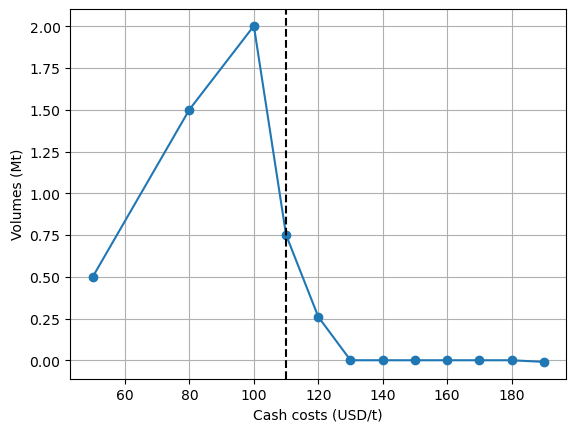

In [120]:
# plot FD
plt.plot(Es, avg_Ns, 'o-')
plt.xlabel('Cash costs (USD/t)')
plt.ylabel('Volumes (Mt)')
plt.axvline(P, color='k', ls='--')
plt.grid()

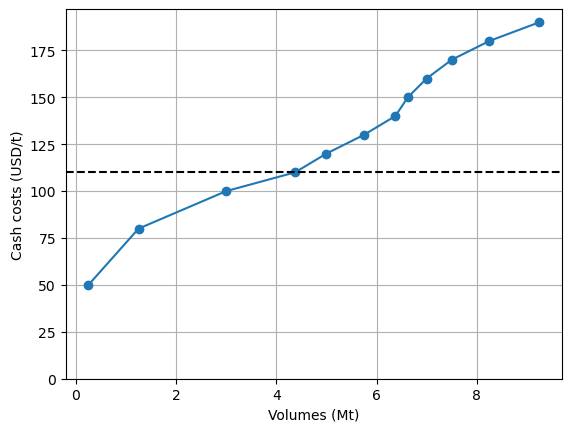

In [121]:
# plot cost curve, ie inverse FD
cum_Caps = np.cumsum(Caps) - Caps / 2
plt.plot(cum_Caps, Es, 'o-')
plt.xlabel('Volumes (Mt)')
plt.ylabel('Cash costs (USD/t)')
plt.axhline(P, color='k', ls='--')
plt.ylim(ymin=0)
plt.grid()

In [122]:
px.line(prices)